# Multi-Well Geophysical Log-Laboratory Data Integration Analysis

## Overview
This notebook performs a comprehensive cross-well analysis to identify consistent correlations and patterns between geophysical log measurements and laboratory analytical results across multiple wells in the HRDH dataset. The analysis focuses on:

- **Data Integration**: Combining and harmonizing datasets from multiple wells
- **Quality Assessment**: Evaluating data completeness and identifying missing patterns  
- **Correlation Analysis**: Finding statistically significant relationships between log and lab measurements
- **Pattern Recognition**: Identifying correlations that persist across multiple wells
- **Visualization**: Creating comprehensive heatmaps and statistical summaries


### Key Outputs
- Correlation matrices by well and combined
- Statistical consistency analysis
- Comprehensive visualization suite
- Exportable datasets for further analysis

# 1. Environment Setup and Library Imports

This section imports all required libraries and configures the analysis environment.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
import missingno as msno
import os
from Module import *

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory for plots
Path('imgs').mkdir(exist_ok=True)


In [6]:
# Add this after your imports or at the beginning of your notebook
LOG_DESCRIPTIONS = {
    'CN':   'Compensated Neutron Porosity',
    'CNC':  'Corrected Compensated Neutron Porosity',
    
    'GR':   'Gamma Ray',
    'GRSL': 'Gamma Ray from 1329 Spectrum',
    
    'HRD1': 'Long Space Spectrum Count Rate 140-200 keV',
    'HRD2': 'Long Space Spectrum Count Rate 200-540 keV',
    
    'K':    'Potassium Content',
    'KTH':  'Stripped Potassium-Thorium',
    
    'LSN':  'Long Space Neutron',
    'PE':   'Photo Electric Cross-Section',
    'SFT2': 'Long Space Spectrum Count Rate 100-140 keV',
    'SHR':  'Soft to Hard Count Rate Ratio',
    'SLTM': 'Delta Elapsed Time',
    'ZDNC': 'Borehole Size/Mud Weight Corrected Density'
}



# 2. Multi-Well Data Loading and Integration

This section loads data from all available wells, handles duplicate columns (particularly in HRDH_1867), and combines them into a unified dataset for cross-well analysis.

In [7]:
# Load all well data with duplicate column fixing
print("Loading data from all wells...")



# Load the data
df_all = load_all_wells_csv_fixed()

# Display basic information
print(f"\nDataset shape: {df_all.shape}")
print(f"Wells included: {sorted(df_all['Well'].unique())}")
print(f"\nSamples per well:")
print(df_all['Well'].value_counts().sort_values(ascending=False))

# Check data completeness by well
print("\nData completeness by well:")
for well in sorted(df_all['Well'].unique()):
    well_data = df_all[df_all['Well'] == well]
    completeness = (1 - well_data.isnull().sum().sum() / (len(well_data) * len(well_data.columns))) * 100
    print(f"  {well}: {completeness:.1f}% complete")

df_all

Loading data from all wells...
Found 4 joined CSV files:
  HRDH_1119\HRDH_1119_joined.csv
  HRDH_1804\HRDH_1804_joined.csv
  HRDH_1867\HRDH_1867_joined.csv
  HRDH_697\HRDH_697_joined.csv
Loaded HRDH_1119: 18 samples, 73 columns
Loaded HRDH_1804: 41 samples, 56 columns
Loaded HRDH_1867: 9 samples, 59 columns
Loaded HRDH_697: 10 samples, 66 columns

Combined dataset: 78 total samples from 4 wells
Total columns after merge: 89

Dataset shape: (78, 89)
Wells included: ['HRDH_1119', 'HRDH_1804', 'HRDH_1867', 'HRDH_697']

Samples per well:
Well
HRDH_1804    41
HRDH_1119    18
HRDH_697     10
HRDH_1867     9
Name: count, dtype: int64

Data completeness by well:
  HRDH_1119: 82.0% complete
  HRDH_1804: 62.9% complete
  HRDH_1867: 66.3% complete
  HRDH_697: 74.2% complete


,Distance,Lab_Depth,Lab_Sample_ID,Lab_XRD_Anatase,Lab_XRD_Anhydrite,Lab_XRD_Ankerite,Lab_XRD_Calcite,Lab_XRD_Chlorite,Lab_XRD_Dickite,Lab_XRD_Dolomite,...,Log_TTEN,Log_U,Log_UC,Log_WRM,Log_WTBH,Log_ZCOR,Log_ZDEN,Log_ZDNC,Match_Type,Well
0,0.00,10742.5,20,NaN,98.4,0,0.0,0.0,NaN,1.5,...,4011.0398,0.243608,NaN,NaN,231.91081,-0.004835,2.946764,2.935852,Exact,HRDH_1119
1,0.10,10743.4,21,NaN,99.3,0,0.0,0.0,NaN,0.7,...,4020.7507,0.017326,NaN,NaN,232.1537,-0.009443,2.929054,2.918051,Near,HRDH_1119
2,0.05,10744.3,22,NaN,96.9,0,0.0,0.0,NaN,3.0,...,4022.0010,0.017326,NaN,NaN,232.22966,-0.013279,2.925855,2.914831,Near,HRDH_1119
3,0.10,10745.4,23,NaN,76.8,0,0.0,0.0,NaN,22.8,...,4011.2126,0.149796,NaN,NaN,231.95135,-0.021489,2.901159,2.890035,Near,HRDH_1119
4,0.00,10746.5,24,NaN,96.1,0,0.0,0.0,NaN,3.7,...,4009.1106,0.528289,NaN,NaN,232.20607,-0.014056,2.889534,2.878369,Exact,HRDH_1119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.20,14903.7,7,NaN,0.0,0,0.0,0.1,NaN,0.0,...,NaN,9.923880,NaN,NaN,,-0.044524,2.493208,2.482956,Near,HRDH_697
74,0.20,14905.7,8,NaN,0.0,0,0.0,0.1,NaN,0.0,...,NaN,10.382340,NaN,NaN,,-0.032361,2.427736,2.417896,Near,HRDH_697
75,0.00,14931.5,14,NaN,0.0,0,0.0,0.1,NaN,0.0,...,NaN,8.952220,NaN,NaN,,-0.059618,2.473074,2.462947,Exact,HRDH_697
76,0.10,14932.4,15,NaN,0.0,0,0.0,0.1,NaN,0.0,...,NaN,10.230805,NaN,NaN,,-0.062772,2.478785,2.468622,Near,HRDH_697


# 3. Dataset Structure Analysis and Variable Classification

This section analyzes the combined dataset structure, classifies variables into log measurements, laboratory results, and metadata, and filters to focus on specific geophysical measurements of interest.

In [8]:

# Only include specific log measurements
specific_logs = ['CN', 'CNC', 'GR', 'GRSL', 'HRD1', 'HRD2', 'K', 'KTH', 'LSN', 
                'PE', 'SFT2', 'SHR', 'SLTM', 'ZDNC']

# Convert to Log_ prefixed names
specific_log_columns = [f'Log_{log}' for log in specific_logs]

# Filter columns
lab_columns = [col for col in df_all.columns if col.startswith('Lab_') and col != 'Lab_Depth' and col != 'Lab_Sample_ID']

# Only include log columns that are in the specific list
all_log_columns = [col for col in df_all.columns if col.startswith('Log_') and col != 'Log_Depth' and col != 'Log_FRAMENO']
log_columns = [col for col in all_log_columns if col in specific_log_columns]

# Check which specific logs are missing
available_logs = [col.replace('Log_', '') for col in log_columns]
missing_logs = [log for log in specific_logs if log not in available_logs]

metadata_columns = ['Lab_Depth', 'Log_Depth', 'Distance', 'Match_Type', 'Well']

# Remove Sample_ID and FRAMENO columns if they exist
columns_to_exclude = ['Lab_Sample_ID', 'Log_FRAMENO', 'Sample_ID', 'FRAMENO']

for col in columns_to_exclude:
    if col in df_all.columns:
        print(f"Excluding column: {col}")
        df_all = df_all.drop(columns=[col])

print(f"Column Classification:")
print(f"Lab measurements: {len(lab_columns)}")
print(f"Log measurements (filtered): {len(log_columns)} out of {len(specific_logs)} requested")
print(f"Available logs: {', '.join(available_logs)}")

if missing_logs:
    print(f"Missing logs: {', '.join(missing_logs)}")
print(f"Metadata: {len(metadata_columns)}")
print(f"Total columns: {len(df_all.columns)}")



Excluding column: Lab_Sample_ID
Excluding column: Log_FRAMENO
Column Classification:
Lab measurements: 35
Log measurements (filtered): 14 out of 14 requested
Available logs: CN, CNC, GR, GRSL, HRD1, HRD2, K, KTH, LSN, PE, SFT2, SHR, SLTM, ZDNC
Metadata: 5
Total columns: 87


# 4. Data Quality Assessment and Missing Value Analysis

This section evaluates data completeness across wells, identifies patterns in missing data, and visualizes data availability to understand limitations for correlation analysis.

Creating comprehensive missing data visualizations by well...


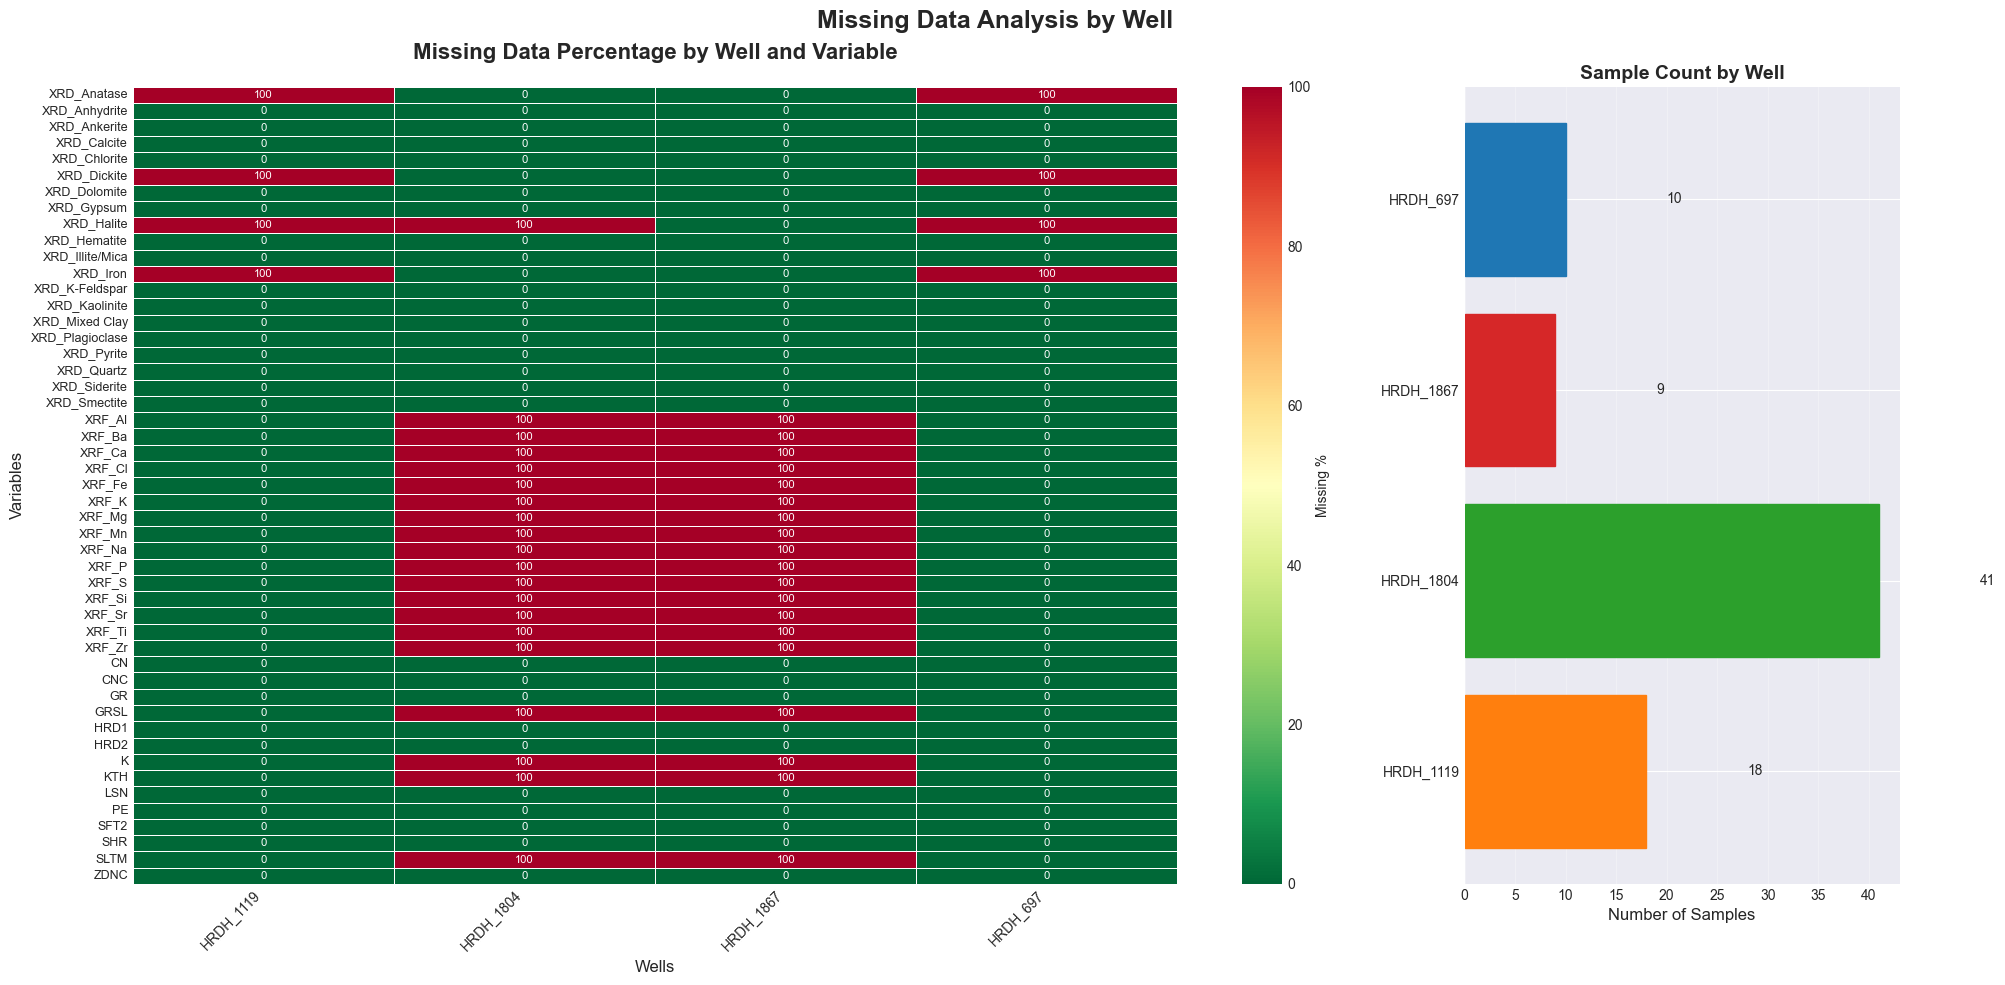


MISSING DATA ANALYSIS SUMMARY

Overall Missing Data by Well:
------------------------------------------------------------
HRDH_1119:
Total samples: 18
Overall missing: 8.2%
Lab data missing: 11.4%
Log data missing: 0.0%
HRDH_1804:
Total samples: 41
Overall missing: 40.8%
Lab data missing: 45.7%
Log data missing: 28.6%
HRDH_1867:
Total samples: 9
Overall missing: 38.8%
Lab data missing: 42.9%
Log data missing: 28.6%
HRDH_697:
Total samples: 10
Overall missing: 8.2%
Lab data missing: 11.4%
Log data missing: 0.0%

Variables with Highest Completeness (>90%):
------------------------------------------------------------
  - XRD_Anhydrite: 100.0% average completeness
  - XRD_Plagioclase: 100.0% average completeness
  - XRD_Ankerite: 100.0% average completeness
  - XRD_Calcite: 100.0% average completeness
  - XRD_Chlorite: 100.0% average completeness
  - XRD_Dolomite: 100.0% average completeness
  - XRD_Gypsum: 100.0% average completeness
  - XRD_Illite/Mica: 100.0% average completeness
  - X

In [9]:

def visualize_missing_data_by_well(df_all, lab_columns, log_columns):
    """
    Create missing data matrix and sample count visualizations grouped by well.
    """
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [3, 1]})
    
    # Get unique wells
    wells = sorted(df_all['Well'].unique())
    well_colors = {
        'HRDH_697': '#1f77b4',
        'HRDH_1119': '#ff7f0e', 
        'HRDH_1804': '#2ca02c',
        'HRDH_1867': '#d62728'
    }
    
    # --- Subplot 1: Missing data matrix by well ---
    all_vars = lab_columns + log_columns
    missing_matrix = []
    
    for well in wells:
        well_data = df_all[df_all['Well'] == well][all_vars]
        missing_row = well_data.isnull().sum() / len(well_data) * 100
        missing_matrix.append(missing_row)
    
    missing_df = pd.DataFrame(missing_matrix, index=wells, columns=all_vars).T
    
    # Create heatmap
    sns.heatmap(missing_df, 
                cmap='RdYlGn_r',  # Red for high missing, Green for low missing
                cbar_kws={'label': 'Missing %'},
                annot=True, 
                fmt='.0f',
                annot_kws={'size': 8},
                linewidths=0.5,
                ax=ax1)
    
    ax1.set_title('Missing Data Percentage by Well and Variable', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Wells', fontsize=12)
    ax1.set_ylabel('Variables', fontsize=12)
    
    # Fix the tick labels
    yticks = ax1.get_yticks()
    if len(yticks) <= len(all_vars):
        step = max(1, len(all_vars) // len(yticks))
        sampled_vars = all_vars[::step][:len(yticks)]
        ax1.set_yticklabels([col.replace('Lab_', '').replace('Log_', '') for col in sampled_vars], 
                            rotation=0, fontsize=9)
    else:
        ax1.set_yticklabels([col.replace('Lab_', '').replace('Log_', '') for col in all_vars], 
                            rotation=0, fontsize=9)
    
    ax1.set_xticklabels(wells, rotation=45, ha='right')
    
    # --- Subplot 2: Sample count by well ---
    sample_counts = df_all['Well'].value_counts().loc[wells]
    bars = ax2.barh(range(len(wells)), sample_counts.values)
    
    # Color bars by well
    for i, (well, bar) in enumerate(zip(wells, bars)):
        bar.set_color(well_colors[well])
        ax2.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
                f'{sample_counts[well]:,}', va='center', fontsize=10)
    
    ax2.set_yticks(range(len(wells)))
    ax2.set_yticklabels(wells)
    ax2.set_xlabel('Number of Samples', fontsize=12)
    ax2.set_title('Sample Count by Well', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.suptitle('Missing Data Analysis by Well', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.savefig('imgs/missing_data_by_well_simple.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("MISSING DATA ANALYSIS SUMMARY")
    print("="*80)
    
    # Calculate missing percentages by well
    print("\nOverall Missing Data by Well:")
    print("-" * 60)
    for well in wells:
        well_data = df_all[df_all['Well'] == well][all_vars]
        total_missing = well_data.isnull().sum().sum()
        total_cells = len(well_data) * len(all_vars)
        missing_pct = (total_missing / total_cells) * 100
        lab_missing = well_data[lab_columns].isnull().sum().sum() / (len(well_data) * len(lab_columns)) * 100 if lab_columns else 0
        log_missing = well_data[log_columns].isnull().sum().sum() / (len(well_data) * len(log_columns)) * 100 if log_columns else 0
        
        print(f"{well}:")
        print(f"Total samples: {len(well_data):,}")
        print(f"Overall missing: {missing_pct:.1f}%")
        print(f"Lab data missing: {lab_missing:.1f}%")
        print(f"Log data missing: {log_missing:.1f}%")
    
    # Variable completeness analysis
    var_completeness = []
    for var in all_vars:
        var_comps = []
        for well in wells:
            well_data = df_all[df_all['Well'] == well][var]
            comp = (1 - well_data.isnull().sum() / len(well_data)) * 100
            var_comps.append(comp)
        var_completeness.append({
            'Variable': var.replace('Lab_', '').replace('Log_', ''),
            'Avg_Completeness': np.mean(var_comps),
            'Min_Completeness': min(var_comps),
            'Max_Completeness': max(var_comps),
            'Range': max(var_comps) - min(var_comps)
        })
    
    var_comp_df = pd.DataFrame(var_completeness)
    var_comp_df = var_comp_df.sort_values('Avg_Completeness', ascending=False)
    
    print("\nVariables with Highest Completeness (>90%):")
    print("-" * 60)
    high_complete = var_comp_df[var_comp_df['Avg_Completeness'] > 90]
    for _, row in high_complete.iterrows():
        print(f"  - {row['Variable']}: {row['Avg_Completeness']:.1f}% average completeness")
    
    print("\nVariables with Lowest Completeness (<50%):")
    print("-" * 60)
    low_complete = var_comp_df[var_comp_df['Avg_Completeness'] < 50]
    for _, row in low_complete.iterrows():
        print(f"  - {row['Variable']}: {row['Avg_Completeness']:.1f}% average completeness")
    
    print("\nVariables with Inconsistent Availability Across Wells:")
    print("-" * 60)
    inconsistent = var_comp_df[var_comp_df['Range'] > 50].sort_values('Range', ascending=False)
    for _, row in inconsistent.head(10).iterrows():
        print(f"  - {row['Variable']}: {row['Min_Completeness']:.1f}% to {row['Max_Completeness']:.1f}% (range: {row['Range']:.1f}%)")

# Call the enhanced visualization function
print("Creating comprehensive missing data visualizations by well...")
visualize_missing_data_by_well(df_all, lab_columns, log_columns)


# 5. Statistical Correlation Analysis and Cross-Well Pattern Recognition

This section performs comprehensive correlation analysis between log and laboratory measurements, categorizes correlations by the number of wells they appear in (2, 3, or 4 wells), and identifies the most consistent and significant relationships across the dataset.

In [10]:
# Calculate correlations for each well
print("Calculating correlations for each well...")
well_correlations = calculate_correlations_by_well(df_all, lab_columns, log_columns)

# Find all correlations categorized by well count
print("\nFinding all correlations by well count...")
correlations_by_well_count = find_all_correlations_by_well_count(
    well_correlations, 
    min_correlation=0.5
)

# Print categorized summary
print_categorized_correlation_summary(correlations_by_well_count, top_n=10)

# For backward compatibility, create common_correlations
common_correlations = find_common_correlations(
    well_correlations, 
    min_correlation=0.5, 
    min_wells=2
)

print(f"\nFound {len(common_correlations)} common correlations (|r| ≥ 0.5 in ≥2 wells)")

# Analyze consistency
consistency_df = analyze_correlation_consistency(common_correlations, well_correlations)

print("\nMost consistent correlations (top 5):")
for i, row in consistency_df.head().iterrows():
    print(f"{i+1}. {row['Variable_Pair']}: σ = {row['Std_r']:.3f}, |r̄| = {abs(row['Mean_r']):.3f}")

print("\nStrongest correlations (top 5):")
strongest = consistency_df.loc[consistency_df['Mean_r'].abs().nlargest(5).index]
for i, (idx, row) in enumerate(strongest.iterrows()):
    print(f"{i+1}. {row['Variable_Pair']}: |r̄| = {abs(row['Mean_r']):.3f}, σ = {row['Std_r']:.3f}")

Calculating correlations for each well...
  HRDH_1119: 238/490 correlations calculated
  HRDH_1804: 50/490 correlations calculated
  HRDH_1867: 90/490 correlations calculated
  HRDH_697: 238/490 correlations calculated

Finding all correlations by well count...

CORRELATION ANALYSIS - CATEGORIZED BY WELL COUNT

Total correlation pairs found: 23

Distribution by well count:
  - 4 wells: 0 pairs (0.0%)
  - 3 wells: 3 pairs (13.0%)
  - 2 wells: 20 pairs (87.0%)


CORRELATIONS IN 4 WELLS: None found


CORRELATIONS IN 3 WELLS (3 total)

Direction consistency:
  - Consistent: 3 (100.0%)
  - Mixed: 0

Top 3 correlations:
--------------------------------------------------------------------------------

1. CN vs XRD_Quartz
   Average |r|: 0.698 (σ = 0.136)
   Type: Negative correlation
   Direction: Consistent
   Well correlations:
     - HRDH_1867: r = -0.859
     - HRDH_697: r = -0.707
     - HRDH_1804: r = -0.527
   Not found in: HRDH_1119

2. CNC vs XRD_Quartz
   Average |r|: 0.697 (σ = 0.1

# Visualize Common Correlations - Combined Scatter Plots


Creating comprehensive scatter plots for common correlations...

Saving 15 individual positive correlation plots...


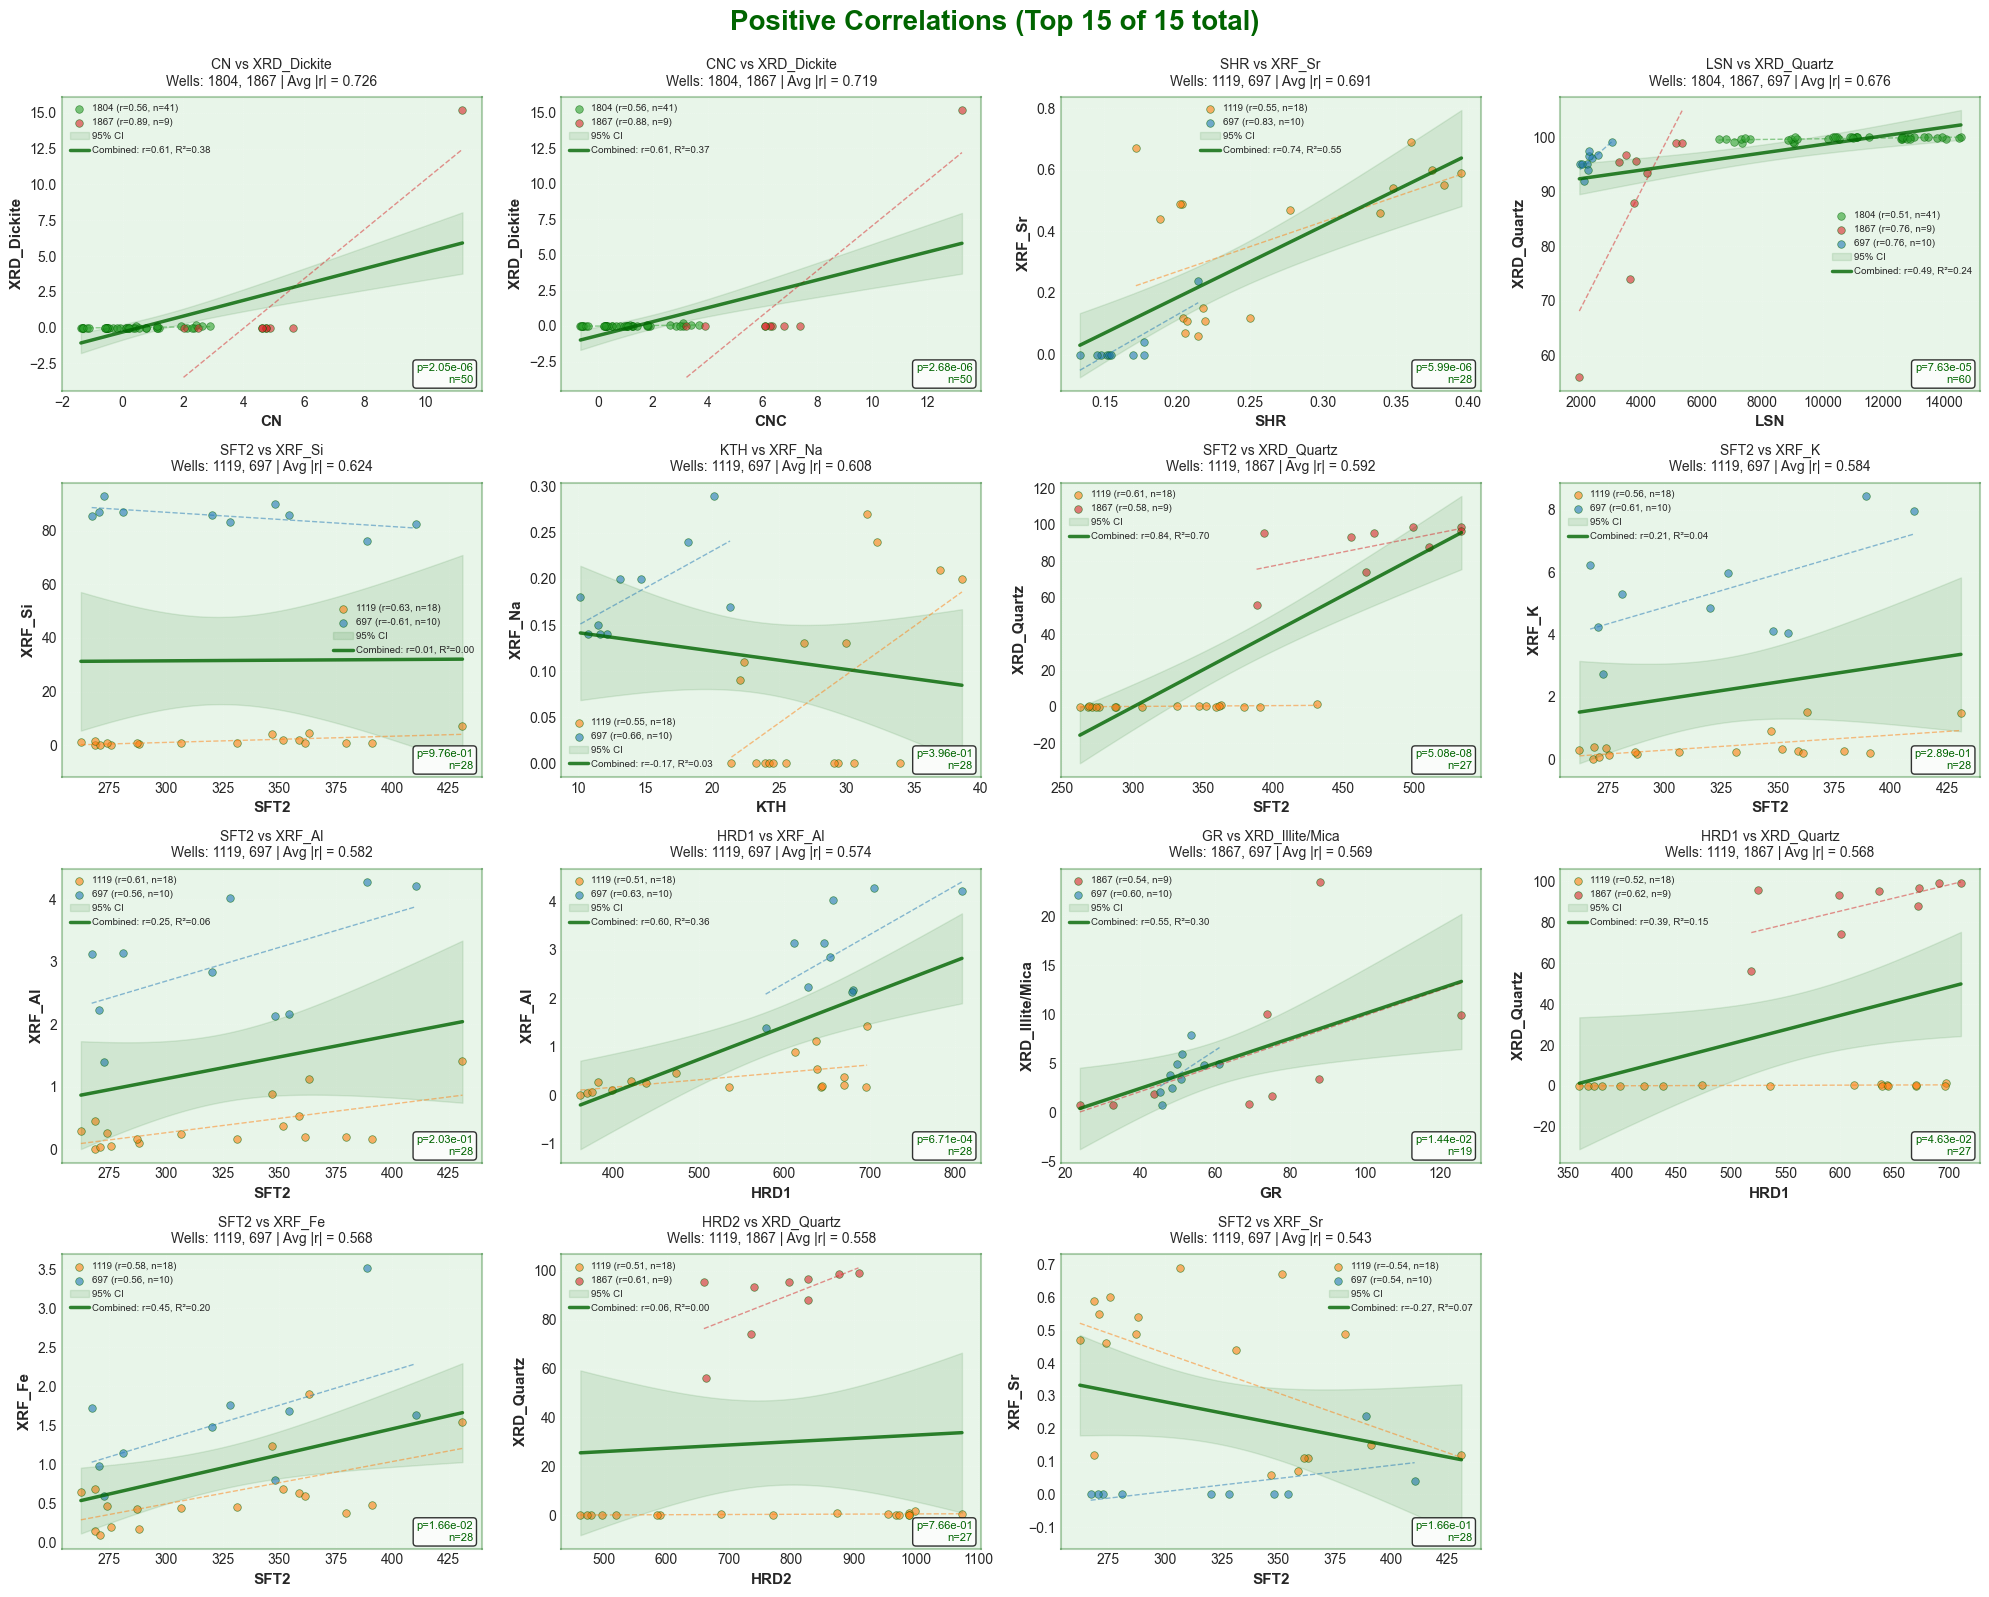

✅ Saved 15 positive correlation plots to: imgs\scatter_plots\positive

Saving 8 individual negative correlation plots...


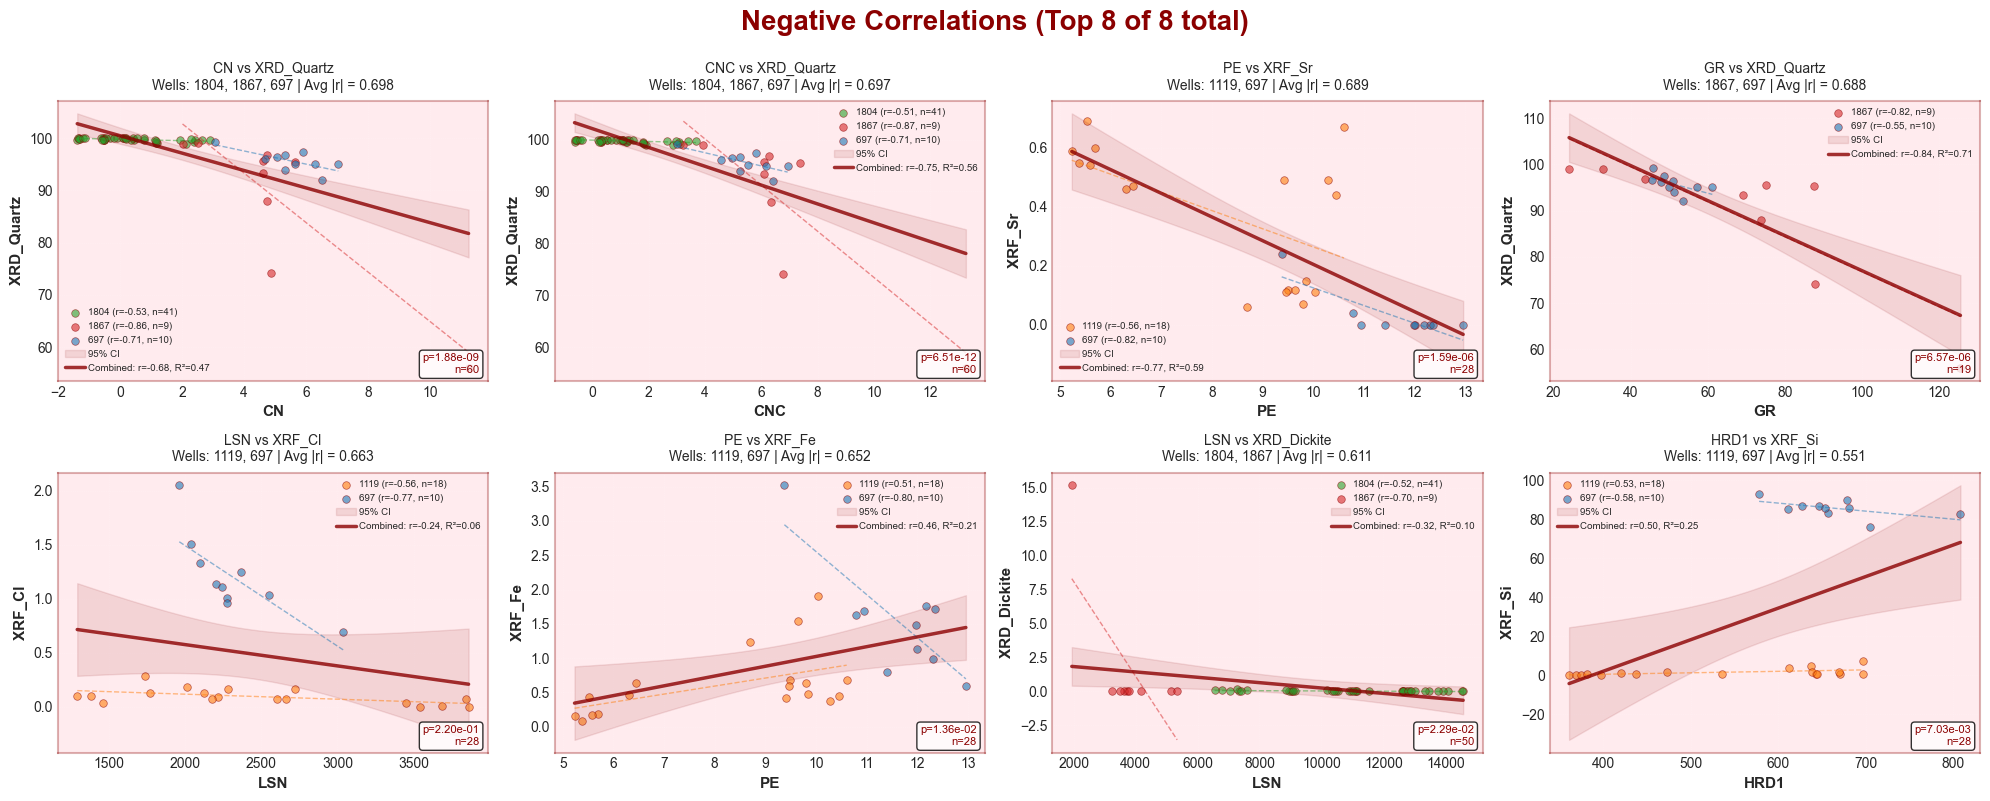

✅ Saved 8 negative correlation plots to: imgs\scatter_plots\negative

SCATTER PLOT GENERATION SUMMARY

INDIVIDUAL PLOTS SAVED:
------------------------------------------------------------
Positive correlations: imgs/scatter_plots/positive/
   - 15 plots saved
Negative correlations: imgs/scatter_plots/negative/
   - 8 plots saved

FILE NAMING CONVENTION:
Format: ###_LogVar_vs_LabVar_rValue.png
### = Ranking by correlation strength
LogVar = Log measurement name
LabVar = Lab measurement name
rValue = Average absolute correlation value

COMBINED PLOTS:
Total positive correlations: 15
Total negative correlations: 8
Total correlations visualized in combined plots: 23

3 wells: 3 total (1 positive, 2 negative)

2 wells: 20 total (14 positive, 6 negative)

Top 10 Positive Correlations:
1. CN vs XRD_Dickite: |r̄| = 0.726 (Wells: 1804, 1867)
2. CNC vs XRD_Dickite: |r̄| = 0.719 (Wells: 1804, 1867)
3. SHR vs XRF_Sr: |r̄| = 0.691 (Wells: 1119, 697)
4. LSN vs XRD_Quartz: |r̄| = 0.676 (Wells: 1804, 1

In [ ]:

'''
Average Correlations vs Combined Correlations

1. Average Correlations
Method: Calculate correlation separately for each well, then take the arithmetic mean
Formula: Average r = (r₁ + r₂ + r₃ + r₄) / 4
What it represents: The typical correlation strength across wells

2. Combined Correlations
Method: Pool ALL data points from ALL wells together, then calculate one correlation
Pooling = Combining all individual data points into one big dataset, regardless of which well they came from.
Formula: Combined r = correlation(all_x_values, all_y_values)
What it represents: The overall relationship across your entire dataset

Key Differences:
1. Statistical Power
2. Weighting
3. Variance Handling

Visual Example:
Imagine you have:

Well 1: 100 data points, r = 0.8
Well 2: 20 data points, r = 0.6
Well 3: 150 data points, r = 0.75
Well 4: 30 data points, r = 0.5

Average correlation: (0.8 + 0.6 + 0.75 + 0.5) / 4 = 0.66
Combined correlation: Would be closer to 0.75 because Wells 1 and 3 have more data points and stronger correlations.

When to Use Each:

Use Average Correlations for:
Summary tables and reports
Comparing well performance
Identifying which wells behave differently
When you want each well to have equal importance

Use Combined Correlations for:
Understanding the true overall relationship
Making predictions across the entire field
Statistical modeling
When you want the most accurate representation of the relationship

Why Combined is Often More Meaningful:
Better represents reality: If one well has 10x more data, it should have more influence
More accurate statistics: p-values and confidence intervals are based on actual sample size
Reduces impact of outlier wells: A well with few noisy points won't skew the results as much
Shows the true field-wide relationship: What you'd expect if you drilled a new well


Average: Shows consistency across wells (are all wells showing similar patterns?)
Combined: Shows the actual relationship in your data (what's the true correlation?)
The difference between them (combined - average) tells you if certain wells are skewing the average or if there's significant variability between wells.
'''

''''
Dashed colored lines: Individual well regression lines (one per well)
Solid black line: Combined regression line from all wells' data pooled together
Gray shaded area: 95% confidence interval band around the combined regression line

'''
# Call the function to create scatter plots
print("Creating comprehensive scatter plots for common correlations...")
create_comprehensive_correlation_scatter_plots(df_all, correlations_by_well_count, max_plots_per_figure=20)


Creating correlation coverage heatmap...

Analyzing correlation distribution...


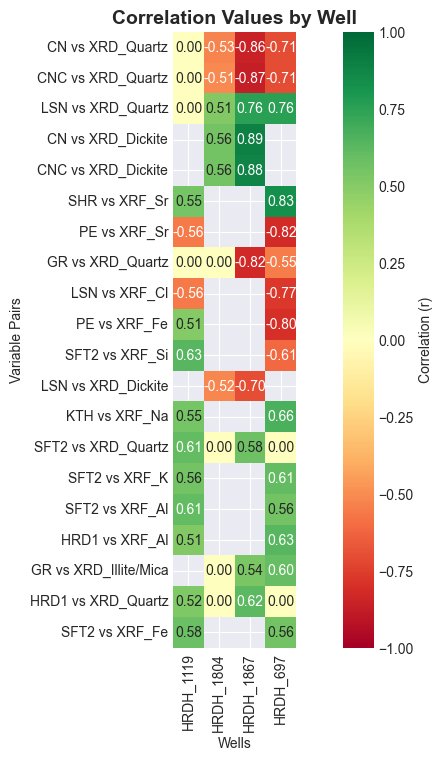

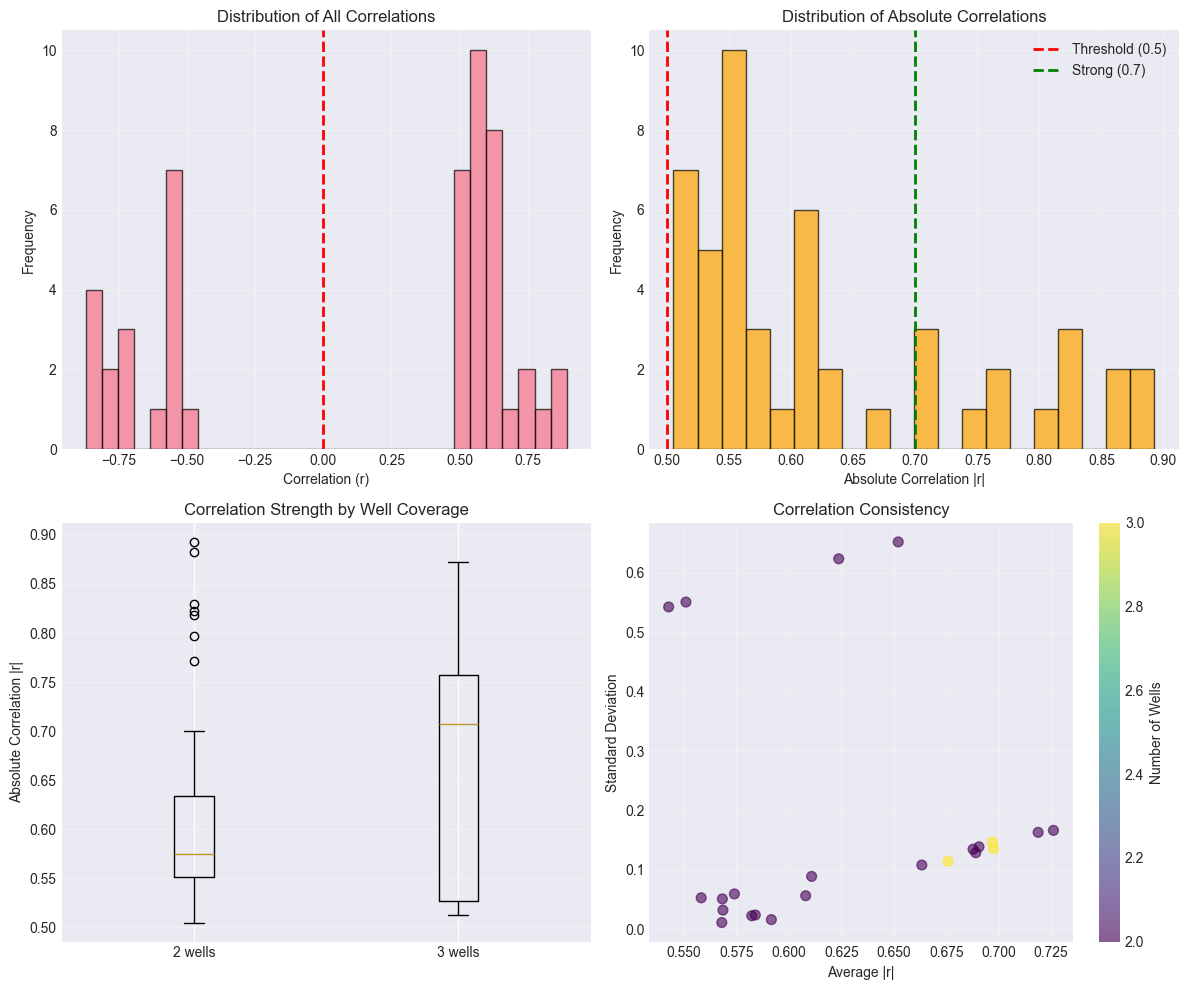


Correlation Distribution Statistics:
Total correlations: 49
Mean |r|: 0.631
Median |r|: 0.580
Std |r|: 0.116
Range: [-0.872, 0.893]

Checking data distribution for top correlations...


Data distribution for Log_CN vs Lab_XRD_Quartz:
Total samples: 78

Log_CN statistics:
count    78.000000
mean      2.983074
std       3.574133
min      -1.378421
25%       0.102501
50%       2.311741
75%       5.405315
max      13.206208
Name: Log_CN, dtype: float64

Lab_XRD_Quartz statistics:
count     78.000000
mean      75.000000
std       41.595932
min        0.000000
25%       77.575000
50%       99.150000
75%       99.900000
max      100.000000
Name: Lab_XRD_Quartz, dtype: float64

Potential outliers in Lab_XRD_Quartz: 18 samples
Outlier range: [0.00, 1.50]
Normal range: [44.09, 133.39]


Data distribution for Log_CNC vs Lab_XRD_Quartz:
Total samples: 78

Log_CNC statistics:
count    78.000000
mean      3.188027
std       3.009129
min      -0.637114
25%       0.856900
50%       2.625841
75%      

In [12]:

# Add this cell after the correlation analysis section (around line 490)

# Call the correlation coverage heatmap function
print("\nCreating correlation coverage heatmap...")
create_correlation_coverage_heatmap(common_correlations, well_correlations, top_n=20)

# Call the correlation distribution analysis function
print("\nAnalyzing correlation distribution...")
analyze_correlation_distribution(common_correlations)

# Example usage of check_data_distribution for top correlations
print("\nChecking data distribution for top correlations...")
# Get the top 3 correlations
top_3_correlations = common_correlations[:3]
for pair, wells_data, info in top_3_correlations:
    log_var, lab_var = pair
    print(f"\n{'='*60}")
    check_data_distribution(df_all, log_var, lab_var)

## Heatmap

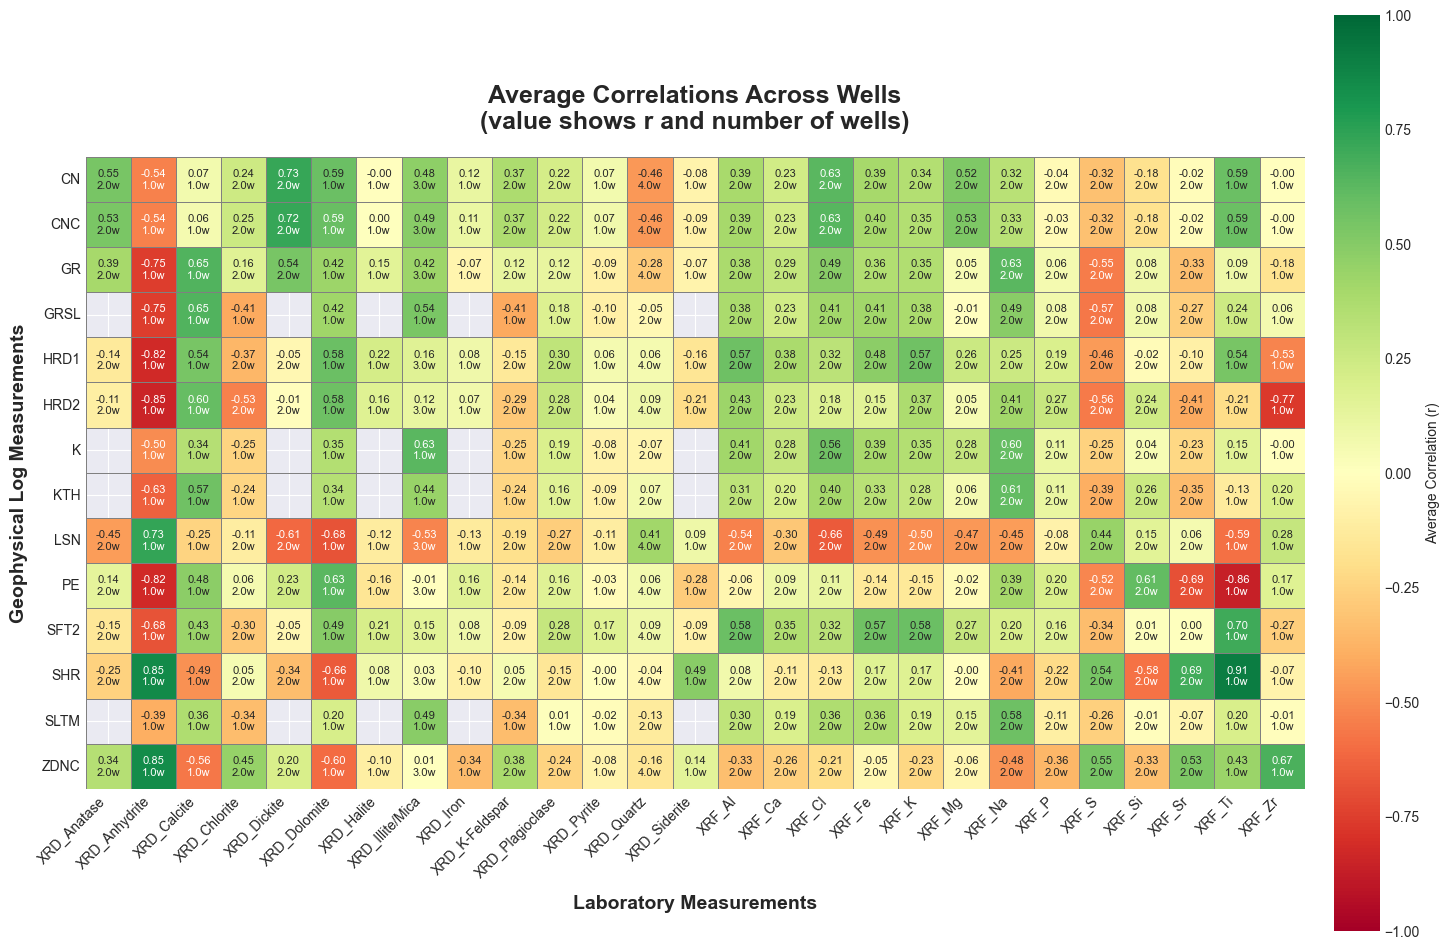

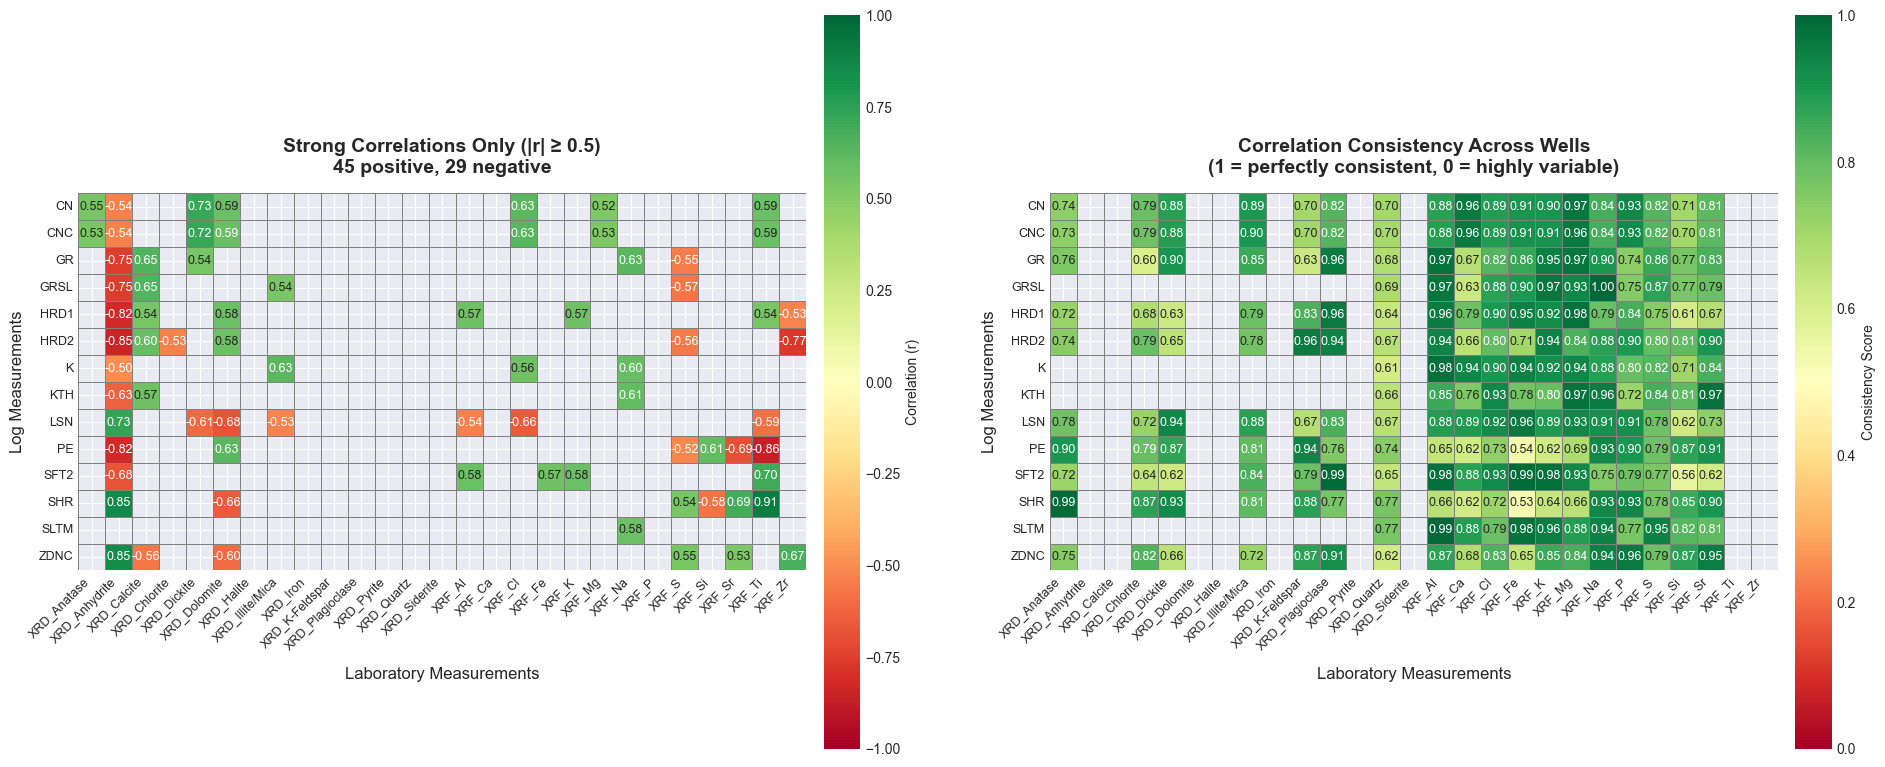

In [13]:

# Call the improved function
create_improved_correlation_heatmaps(well_correlations, correlations_by_well_count, df_all, lab_columns, log_columns)


Creating combined correlation heatmaps...


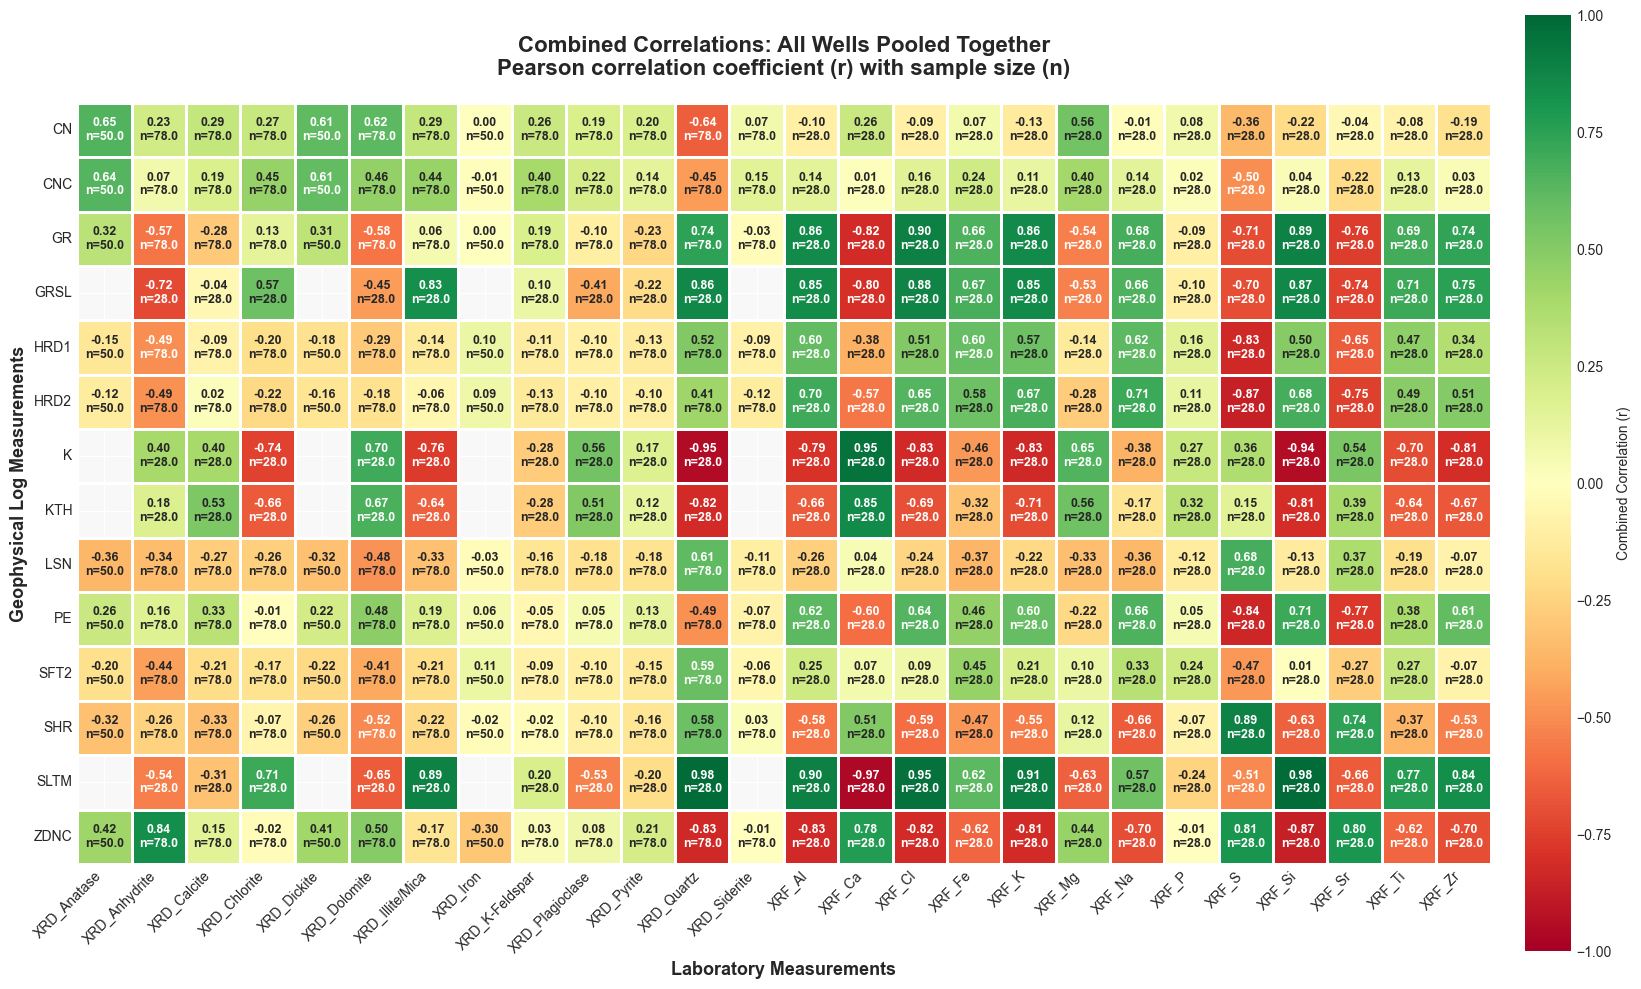

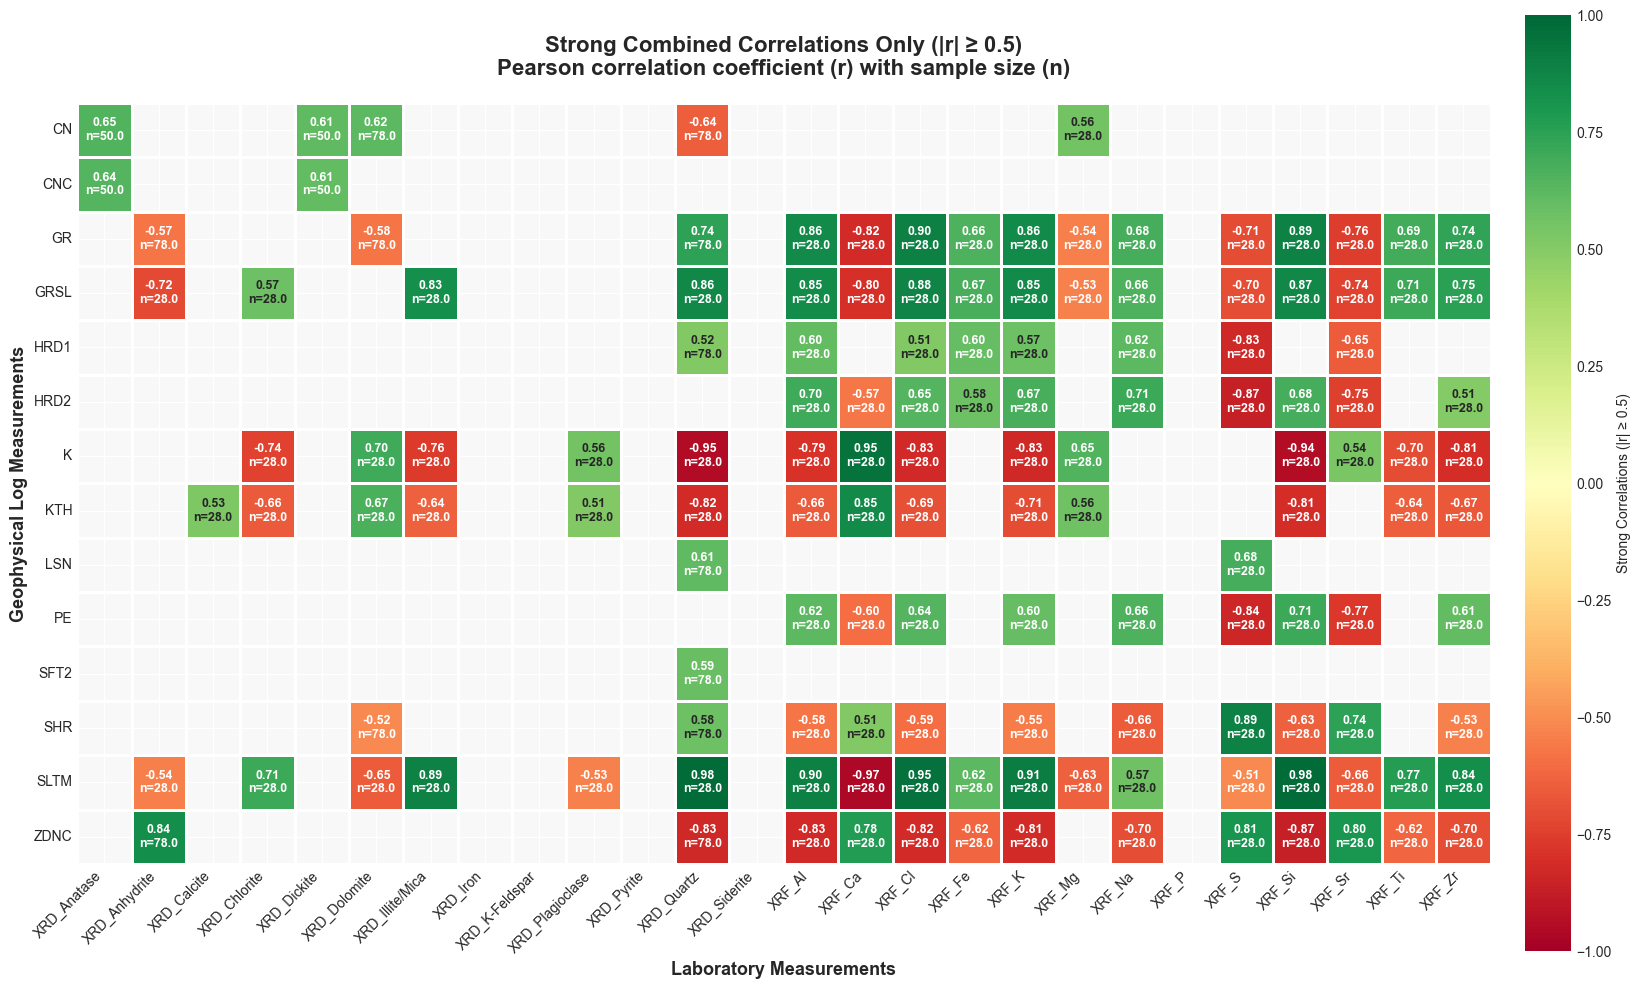


COMBINED CORRELATION ANALYSIS - IMPROVED SUMMARY

📊 CORRELATION STRENGTH DISTRIBUTION:
------------------------------------------------------------
Very Strong (|r| ≥ 0.7): 64 pairs (18.4%)
Strong (|r| ≥ 0.5): 138 pairs (39.7%)
Moderate (|r| ≥ 0.3): 194 pairs (55.7%)

📈 SAMPLE SIZE DISTRIBUTION:
------------------------------------------------------------
Range: nan - nan samples
Mean: nan samples
Median: nan samples

🎯 HIGHEST CONFIDENCE CORRELATION:
------------------------------------------------------------
ZDNC vs XRD_Anhydrite
r = 0.840, n = 78.0


In [14]:


# Call the function to create combined correlation heatmaps
print("\nCreating combined correlation heatmaps...")
combined_corr_matrix, sample_size_matrix = create_combined_correlation_heatmap(
    df_all, lab_columns, log_columns, well_correlations
)

# Summary Statistics and Export


In [15]:
# Create summary report
print("=" * 80)
print("COMBINED WELL ANALYSIS SUMMARY")
print("=" * 80)
print(f"\nDataset Overview:")
print(f"Total samples: {len(df_all):,}")
print(f"Number of wells: {df_all['Well'].nunique()}")
print(f"Lab variables: {len(lab_columns)}")
print(f"Log variables: {len(log_columns)}")

print(f"\nData Quality:")
overall_completeness = (1 - df_all.isnull().sum().sum() / (len(df_all) * len(df_all.columns))) * 100
print(f"Overall completeness: {overall_completeness:.1f}%")

# Calculate high missing columns
missing_pct = df_all.isnull().sum() / len(df_all) * 100
high_missing = missing_pct[missing_pct > 50]
print(f"Columns with >50% missing: {len(high_missing)}")

print(f"\nCorrelation Analysis:")
print(f"Variable pairs with |r| ≥ 0.5 in ≥2 wells: {len(common_correlations)}")

# Check if consistency_df exists and is not empty
if 'consistency_df' in locals() and not consistency_df.empty:
    most_consistent = consistency_df.iloc[0]
    strongest_corr = consistency_df.loc[consistency_df['Mean_r'].abs().idxmax()]
    
    print(f"Most consistent correlation: {most_consistent['Variable_Pair']} (σ = {most_consistent['Std_r']:.3f})")
    print(f"Strongest average correlation: {strongest_corr['Variable_Pair']} (r̄ = {strongest_corr['Mean_r']:.3f})")

# Create comprehensive summary table
print("\nCreating comprehensive summary table...")
summary_data = []

for n_wells in [4, 3, 2]:
    if n_wells in correlations_by_well_count:
        correlations = correlations_by_well_count[n_wells]
        for pair, wells_data, info in correlations:
            log_var, lab_var = pair
            
            row = {
                'N_Wells': n_wells,
                'Log_Variable': log_var,
                'Lab_Variable': lab_var,
                'Avg_Correlation': info['avg_corr'],
                'Avg_Abs_Correlation': info['avg_abs_corr'],
                'Std_Correlation': info['std_corr'],
                'Correlation_Type': info['correlation_type'],
                'Consistent_Direction': info['consistent_direction']
            }
            
            # Add individual well correlations
            for well, r in wells_data:
                row[f'{well}_r'] = r
            
            # Add missing wells
            for well in info['missing_wells']:
                row[f'{well}_r'] = np.nan
                
            summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

if not summary_df.empty:
    # Reorder columns
    base_cols = ['N_Wells', 'Log_Variable', 'Lab_Variable', 'Avg_Correlation', 
                 'Avg_Abs_Correlation', 'Std_Correlation', 'Correlation_Type', 'Consistent_Direction']
    well_cols = sorted([col for col in summary_df.columns if col.endswith('_r')])
    summary_df = summary_df[base_cols + well_cols]
    
    # Sort by N_Wells and Avg_Abs_Correlation
    summary_df = summary_df.sort_values(['N_Wells', 'Avg_Abs_Correlation'], ascending=[False, False])
    
    print(f"✅ Summary table created with {len(summary_df)} correlation pairs")
else:
    print("⚠️ No correlation data found for summary table")

COMBINED WELL ANALYSIS SUMMARY

Dataset Overview:
Total samples: 78
Number of wells: 4
Lab variables: 35
Log variables: 14

Data Quality:
Overall completeness: 68.4%
Columns with >50% missing: 33

Correlation Analysis:
Variable pairs with |r| ≥ 0.5 in ≥2 wells: 23
Most consistent correlation: SFT2 vs XRF_Fe (σ = 0.011)
Strongest average correlation: CN vs XRD_Dickite (r̄ = 0.726)

Creating comprehensive summary table...
✅ Summary table created with 23 correlation pairs


In [16]:
# Export results
print("Exporting results...")

# Save comprehensive summary table
if not summary_df.empty:
    summary_df.to_csv('imgs/correlation_summary_by_wells.csv', index=False)
    print("✅ Comprehensive summary saved to: imgs/correlation_summary_by_wells.csv")

# Save common correlations in simple format
common_corr_records = []
for item in common_correlations:
    if len(item) == 3:
        pair, wells_data, info = item
    else:
        pair, wells_data = item
        info = {}
    
    log_var, lab_var = pair
    for well, r in wells_data:
        common_corr_records.append({
            'Log_Variable': log_var,
            'Lab_Variable': lab_var,
            'Well': well,
            'Correlation': r,
            'N_Wells': info.get('n_wells', len(wells_data)),
            'Avg_Abs_Corr': info.get('avg_abs_corr', np.nan)
        })

if common_corr_records:
    common_corr_df = pd.DataFrame(common_corr_records)
    common_corr_df.to_csv('imgs/common_correlations_all_wells.csv', index=False)
    print("Common correlations saved to: imgs/common_correlations_all_wells.csv")

# Save consistency analysis
if not consistency_df.empty:
    consistency_df.to_csv('imgs/correlation_consistency_analysis.csv', index=False)
    print("Consistency analysis saved to: imgs/correlation_consistency_analysis.csv")



Exporting results...
✅ Comprehensive summary saved to: imgs/correlation_summary_by_wells.csv
Common correlations saved to: imgs/common_correlations_all_wells.csv
Consistency analysis saved to: imgs/correlation_consistency_analysis.csv
